## Libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')
# tensorflow gpu check
# !pip install tensorflow 
import tensorflow as tf

# Check if tensorflow is using GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))



GPU Available:  []


In [2]:
## Change the working dir to the project folder --- run only if needed
import os
os.getcwd()
# os.chdir('/content/drive/MyDrive/Sr.DS Assgn/')

'e:\\Mstat\\Deep_Learning\\DL-final_project\\transfer-learning\\orientation_detection'

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

#please import any required libraries
import os
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
from matplotlib.image import imread
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import save_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

import keras
import cv2
# from PIL import Image, ImageOps
seed = 23
np.random.seed(seed=seed)


In [5]:
# check for GPU compatability
tf.test.gpu_device_name()


''

In [6]:
# data is in "data" folder, contains 9 classes. Needs to be organised in seperate folders before
## Preparing Data folders for train, validation, test
folders  = os.listdir('data/raw')
print(folders)
class_lbl = {k: v for  k, v in enumerate(folders)}
print(class_lbl)

['3_4th_driver_side_front', '3_4th_driver_side_rear', '3_4th_passenger_side_front', '3_4th_passenger_side_rear', 'driver_side', 'front', 'passenger_side', 'rear', 'unknown']
{0: '3_4th_driver_side_front', 1: '3_4th_driver_side_rear', 2: '3_4th_passenger_side_front', 3: '3_4th_passenger_side_rear', 4: 'driver_side', 5: 'front', 6: 'passenger_side', 7: 'rear', 8: 'unknown'}


## Read and Analyse the Data

## ***Key Insights***
  ### Data looks inconsistent with varying sizes ((480, 640, 3) & (768, 1024, 3))
  ### It needs to be resized to common shape.
  ### Data needs to be generated using Agumentation.
  ### Should not be Fliped nor rotate more than 45.
  ### 'Unknown' class  already exists, so model can avoid Open set recognition
#  ### Built in preprocessing function can be used from pretrained models

data/raw\unknown\207661.jpg
(768, 1024, 3)
(480, 640, 3)
(768, 1024, 3)
(768, 1024, 3)
(480, 640, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)


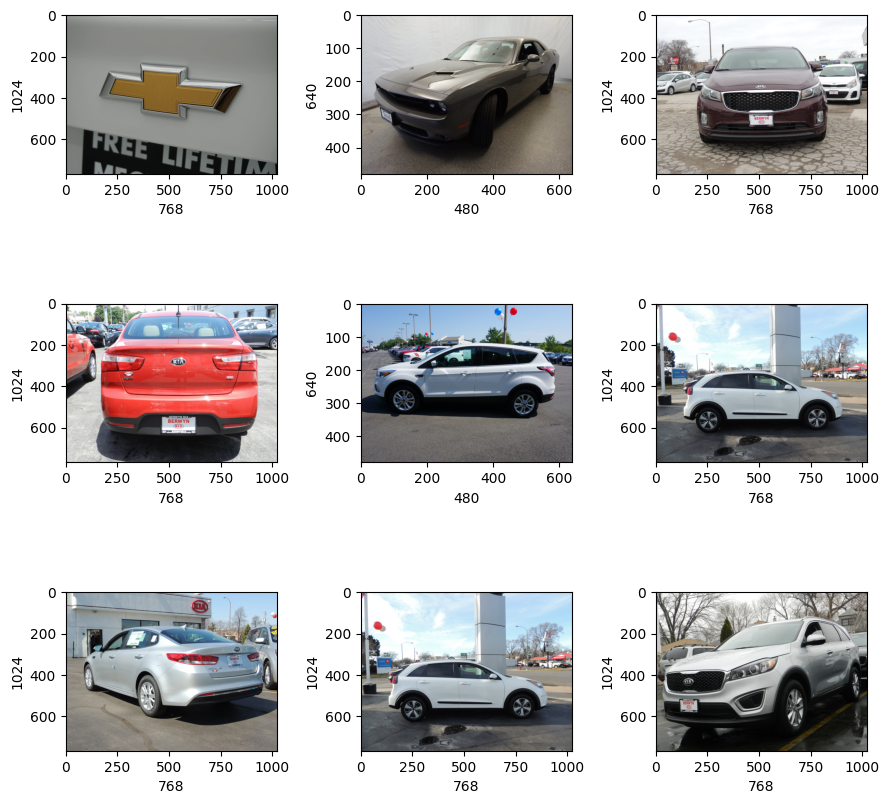

In [9]:
## Checking random images from all folders by picking randomly each time
l = []
for cls in random.sample(folders, 9):
  for f in random.sample(os.listdir(os.path.join('data/raw', cls)), 9):
    if f not in folders:
      l.append(os.path.join('data/raw', cls, f))
n = 9
num_row, num_col = 3, 3
fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
print(l[random.randint(0,len(l))])
for i in range(n):
  img = imread(str(random.choice(l)))
  ax = axes[i // num_col, i % num_col]
  ax.set_xlabel(f'{img.shape[0]}')
  ax.set_ylabel(f'{img.shape[1]}')
  print(img.shape)
  ax.imshow(img)
      
plt.tight_layout()
plt.show()

## Key Points
  ### Data looks inconsistent with varying sizes ((480, 640, 3) & (768, 1024, 3))
  ### It needs to be resized to common shape.
  ### Data needs to be generated using Agumentation.
  ### Should not be Fliped nor rotate more than 45.
  ### 'Unknown' class  already exists no need to create to avoid Open set recognition problem
  ### built in preprocessing fuction can be used 


## Splitting Data

In [10]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, TRAIN_SIZE, VALID_SIZE):
    labels = os.listdir(SOURCE)
    for label in labels:
        files = []
        label_dir = os.path.join(SOURCE, label)
        for filename in os.listdir(label_dir):
            file = os.path.join(label_dir, filename)
            if os.path.getsize(file) > 0:
                files.append(filename)
            else:
                print(filename + " is zero length, so ignoring.")

        training_length = int(len(files) * TRAIN_SIZE)
        valid_length = int(len(files) * VALID_SIZE)
        test_length = int(len(files) - (training_length + valid_length))
        shuffled_set = random.sample(files, len(files))
        training_set = shuffled_set[0:training_length]
        valid_set = shuffled_set[training_length:(training_length+valid_length)]
        test_set = shuffled_set[(training_length+valid_length):]

        for destination, dataset in zip([TRAINING, VALIDATION, TEST], [training_set, valid_set, test_set]):
            dataset_dir = os.path.join(destination, label)
            os.makedirs(dataset_dir, exist_ok=True)
            for filename in dataset:
                this_file = os.path.join(label_dir, filename)
                destination_file = os.path.join(dataset_dir, filename)
                copyfile(this_file, destination_file)

split_data('data/raw', 'data/train', 'data/validation', 'data/test', 0.8, 0.1)

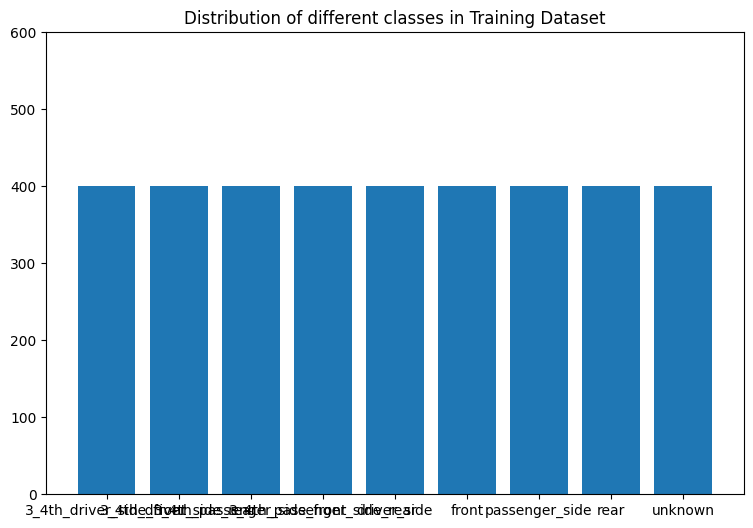

In [11]:
# Distribution of classes in train set after random splitting
image_folder = ['3_4th_driver_side_front', '3_4th_driver_side_rear',
                '3_4th_passenger_side_front', '3_4th_passenger_side_rear',
                'driver_side', 'front', 'passenger_side', 'rear', 'unknown']
nimgs = {}

for i in image_folder:
    nimages = len(os.listdir('data/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.ylim(0, 600)
plt.show()


## Define Generator initialisation

In [12]:
#  Pre-Processing & Data Augumentation
## Data Augumentation Generator
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    # rescale = 1/255.0, # No need to scale as the inceptionV3 model already scales data between (-1,1)
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=False
    )

## Pre-Processing image by resizing as there are varying sizes as we found from above 
img_width = 224
img_height = 224
batch_size = 32 # increasing batch size will cause a problem during validation 

TRAINING_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'
TEST_DIR = 'data/test/'

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)



Found 3600 images belonging to 9 classes.
Found 450 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


### **Visualization After Transformation**

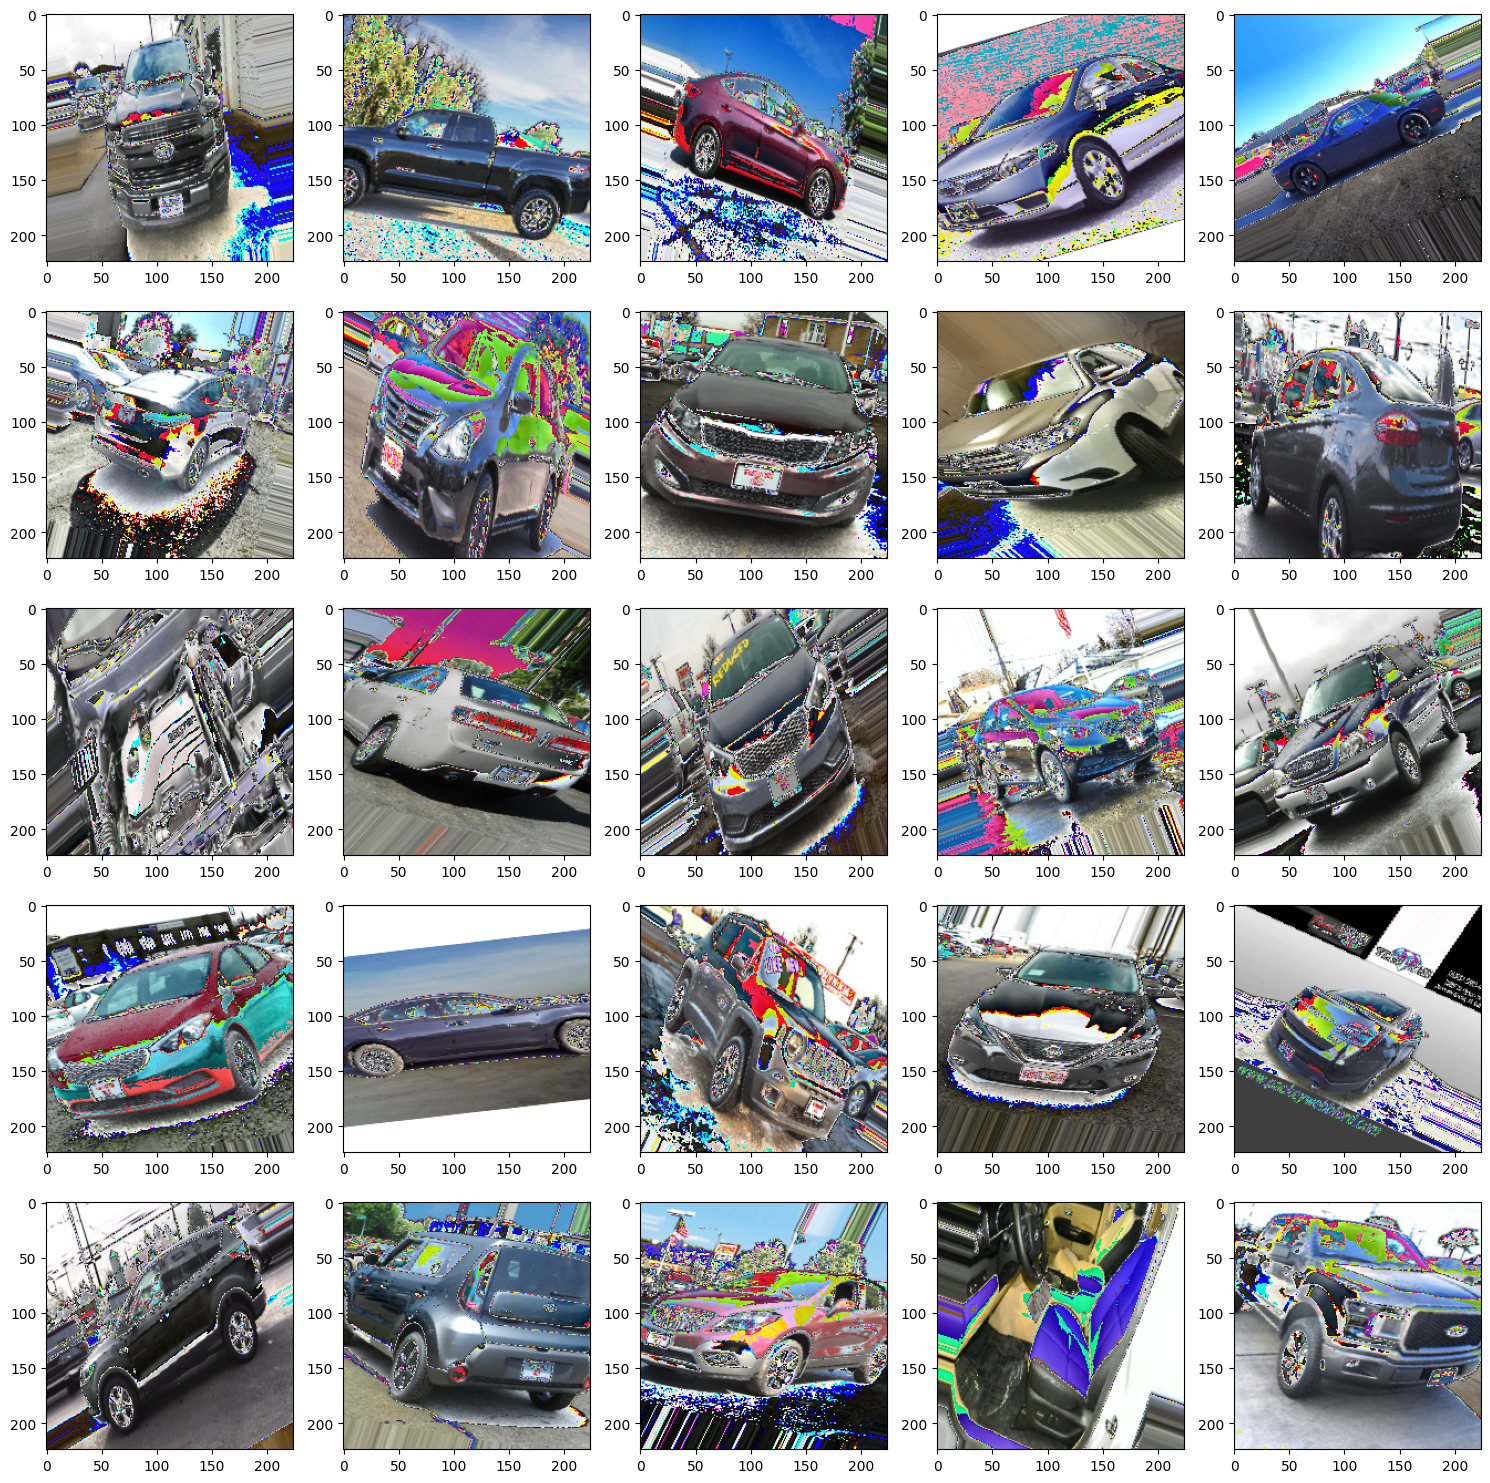

In [13]:
## Visualize First batch of train data
first_batch = train_generator.next()
# first_batch[0][0]
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    """Visualize a batch of train data
    
    Args:
        batch: tf.keras.preprocessing.image.DirectoryIterator
        
    Returns:
        Plot """
    
    n = 25
    num_row, num_col = 5, 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    
    for i in range(n):
        img = np.array(batch[0][i] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        
    plt.tight_layout()
    plt.show()

visualize_batch(batch=first_batch)

## Defining Base Model (Trained models)

In [63]:
# add Fully connected last layers( as many as you like to improve the performance), 
#try-out drop-out in Fully connected layers if you think it is necessary
def add_last_layer(model, n_classes, fc_layer_size):
    
    ## Add your code here
    return Model

def add_new_last_layer(base_model, n_classes, fc_layer_size):
    """Add last layer to the convnet
    
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
        
    Returns:
        new keras model with last layer
    """
    base_model_output = base_model.output
    # x = MaxPooling2D()(base_model_output)
    x = Dropout(0.4)(base_model_output)
    model_flat = Flatten()(x)
    # model_flat = Dense(fc_layer_size, activation='relu')(model_flat)
    predictions = Dense(n_classes, activation='softmax', name='predictions')(model_flat)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model 

model = InceptionV3(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
# model.summary()
for i in model.layers:
  i.trainable=False

# Add new last layer with adjusted size (e.g., 256 neurons)
model = add_new_last_layer(model, n_classes=9, fc_layer_size= (256))

In [64]:
# model.layers.trainable
sum([i.trainable for i in model.layers])

3

## Compiling Model

In [65]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
# lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5, verbose=1)
# #Add callbacks like early stopping, cyclical or variable learning rate or anyting you feel necessary
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
opt_rms = RMSprop(learning_rate=lr_schedule)

model_path = 'model/'
log_dir = 'logs/'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights2.h5')
callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=0),
        keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False, write_images=False)
    ]

##add model compile code here 
model.compile(optimizer=opt_rms, loss='categorical_crossentropy', metrics=["accuracy"])

In [66]:
# chack classes in train_generator
train_generator.class_indices
train_generator.samples // batch_size

112

## Training

In [67]:
## Freeze some layers first and then train the unfrozen layers it. (experiment with number of layers to freeze for best metrics)

## Next train all the layers
train_samples = 3600  # 400*9 classes
history_tl = model.fit_generator(train_generator,
                        steps_per_epoch=train_generator.samples // batch_size,
                        epochs= 30,
                        validation_data=validation_generator,
                        validation_steps= validation_generator.samples // batch_size,
                        callbacks=callbacks_list,
                        verbose=1)


C:\Users\bhanu\AppData\Local\Temp\ipykernel_12764\834517293.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_tl = model.fit_generator(train_generator,


Epoch 1/30
112/112 [==============================] - ETA: 0s - loss: 2.1480 - accuracy: 0.2990
Epoch 1: val_accuracy improved from -inf to 0.51116, saving model to e:\Mstat\Deep_Learning\DL-final_project\transfer-learning\orientation_detection\model\top_model_weights2.h5


e:\Mstat\Deep_Learning\DL-final_project\.conda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 72s 623ms/step - loss: 2.1480 - accuracy: 0.2990 - val_loss: 1.3599 - val_accuracy: 0.5112
Epoch 2/30
112/112 [==============================] - ETA: 0s - loss: 1.4231 - accuracy: 0.4865
Epoch 2: val_accuracy improved from 0.51116 to 0.69196, saving model to e:\Mstat\Deep_Learning\DL-final_project\transfer-learning\orientation_detection\model\top_model_weights2.h5
112/112 [==============================] - 68s 604ms/step - loss: 1.4231 - accuracy: 0.4865 - val_loss: 0.8977 - val_accuracy: 0.6920
Epoch 3/30
112/112 [==============================] - ETA: 0s - loss: 1.0646 - accuracy: 0.6172
Epoch 3: val_accuracy improved from 0.69196 to 0.74107, saving model to e:\Mstat\Deep_Learning\DL-final_project\transfer-learning\orientation_detection\model\top_model_weights2.h5
112/112 [==============================] - 68s 603ms/step - loss: 1.0646 - accuracy: 0.6172 - val_loss: 0.7205 - val_accuracy: 0.7411
Epoch 4/30
112/112 [==========================

In [68]:
model.save('model/model_optimized')

INFO:tensorflow:Assets written to: model/model_optimized\assets


INFO:tensorflow:Assets written to: model/model_optimized\assets


In [98]:
model = keras.models.load_model('model/model_optimized')


In [99]:
# model.save_weights('model/model_weights')
model.load_weights()

TypeError: Model.load_weights() missing 1 required positional argument: 'filepath'

In [30]:
model2=model

model2.load_weights('model/top_model_weights.h5')


### **Train History Diagnostics**

In [72]:
import json
history_dict = model.history.history
history_dict


{'loss': [2.148035764694214,
  1.4230715036392212,
  1.0646467208862305,
  0.8619961142539978,
  0.7308362126350403,
  0.634696364402771,
  0.5592734217643738,
  0.546991229057312,
  0.454664945602417,
  0.41902706027030945,
  0.4040968418121338,
  0.3802160322666168,
  0.3475489616394043,
  0.33378708362579346,
  0.3109651803970337,
  0.2949361503124237,
  0.3002978265285492,
  0.27668702602386475,
  0.2595701217651367,
  0.2513267695903778,
  0.23811417818069458,
  0.22591710090637207,
  0.21437497437000275,
  0.21793566644191742,
  0.21545201539993286,
  0.21024951338768005,
  0.19526131451129913,
  0.1862858682870865,
  0.1921287178993225,
  0.19440357387065887],
 'accuracy': [0.2990470826625824,
  0.4865470826625824,
  0.6171524524688721,
  0.691423773765564,
  0.7413116693496704,
  0.7687780261039734,
  0.7945627570152283,
  0.8094170689582825,
  0.8410874605178833,
  0.8511771559715271,
  0.8626681566238403,
  0.8705157041549683,
  0.8800448179244995,
  0.8848094344139099,
  0.8

In [71]:
from matplotlib import rcParams
# import pandas as pd

initial_history = {'history': history_dict}
# initial_history.history = history_dict
print(initial_history['history'])

{'loss': [2.148035764694214, 1.4230715036392212, 1.0646467208862305, 0.8619961142539978, 0.7308362126350403, 0.634696364402771, 0.5592734217643738, 0.546991229057312, 0.454664945602417, 0.41902706027030945, 0.4040968418121338, 0.3802160322666168, 0.3475489616394043, 0.33378708362579346, 0.3109651803970337, 0.2949361503124237, 0.3002978265285492, 0.27668702602386475, 0.2595701217651367, 0.2513267695903778, 0.23811417818069458, 0.22591710090637207, 0.21437497437000275, 0.21793566644191742, 0.21545201539993286, 0.21024951338768005, 0.19526131451129913, 0.1862858682870865, 0.1921287178993225, 0.19440357387065887], 'accuracy': [0.2990470826625824, 0.4865470826625824, 0.6171524524688721, 0.691423773765564, 0.7413116693496704, 0.7687780261039734, 0.7945627570152283, 0.8094170689582825, 0.8410874605178833, 0.8511771559715271, 0.8626681566238403, 0.8705157041549683, 0.8800448179244995, 0.8848094344139099, 0.8963004350662231, 0.9010650515556335, 0.9019058346748352, 0.9049887657165527, 0.91031390

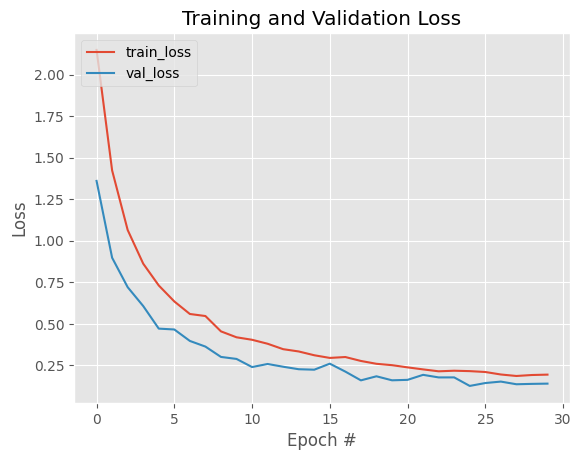

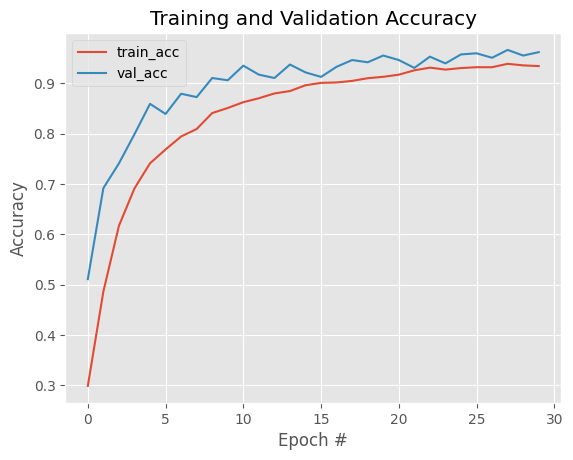

In [73]:
# plot the training and validation loss
N = len(initial_history['history']["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), initial_history['history']["loss"], label="train_loss")
plt.plot(np.arange(0, N), initial_history['history']["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

# plot the training and validation accuracy
plt.figure()
plt.plot(np.arange(0, N), initial_history['history']["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), initial_history['history']["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()


## Testing

In [74]:
## Test data preprocessing (With same preprocessing function from train & validation)
test_generator
# Picking the best model weights for testing
# top_weights_path = os.path.join('model/', 'top_model_weights.h5')
pred = model.evaluate(test_generator,verbose=1, steps=32)
pred

15/32 [=============>................] - ETA: 10s - loss: 0.1301 - accuracy: 0.9578WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 32 batches). You may need to use the repeat() function when building your dataset.


32/32 [==============================] - 9s 278ms/step - loss: 0.1301 - accuracy: 0.9578


[0.13006357848644257, 0.9577777981758118]

In [75]:
n_batches = len(test_generator)

cm=confusion_matrix(
    np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1) 
)

cm


C:\Users\bhanu\AppData\Local\Temp\ipykernel_12764\417894730.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1)


array([[49,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 46,  1,  1,  1,  1,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 47,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 47,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 49,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0, 48,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1, 48]], dtype=int64)

In [61]:
np.where(cm[6] != 0)[0]

array([4, 6], dtype=int64)

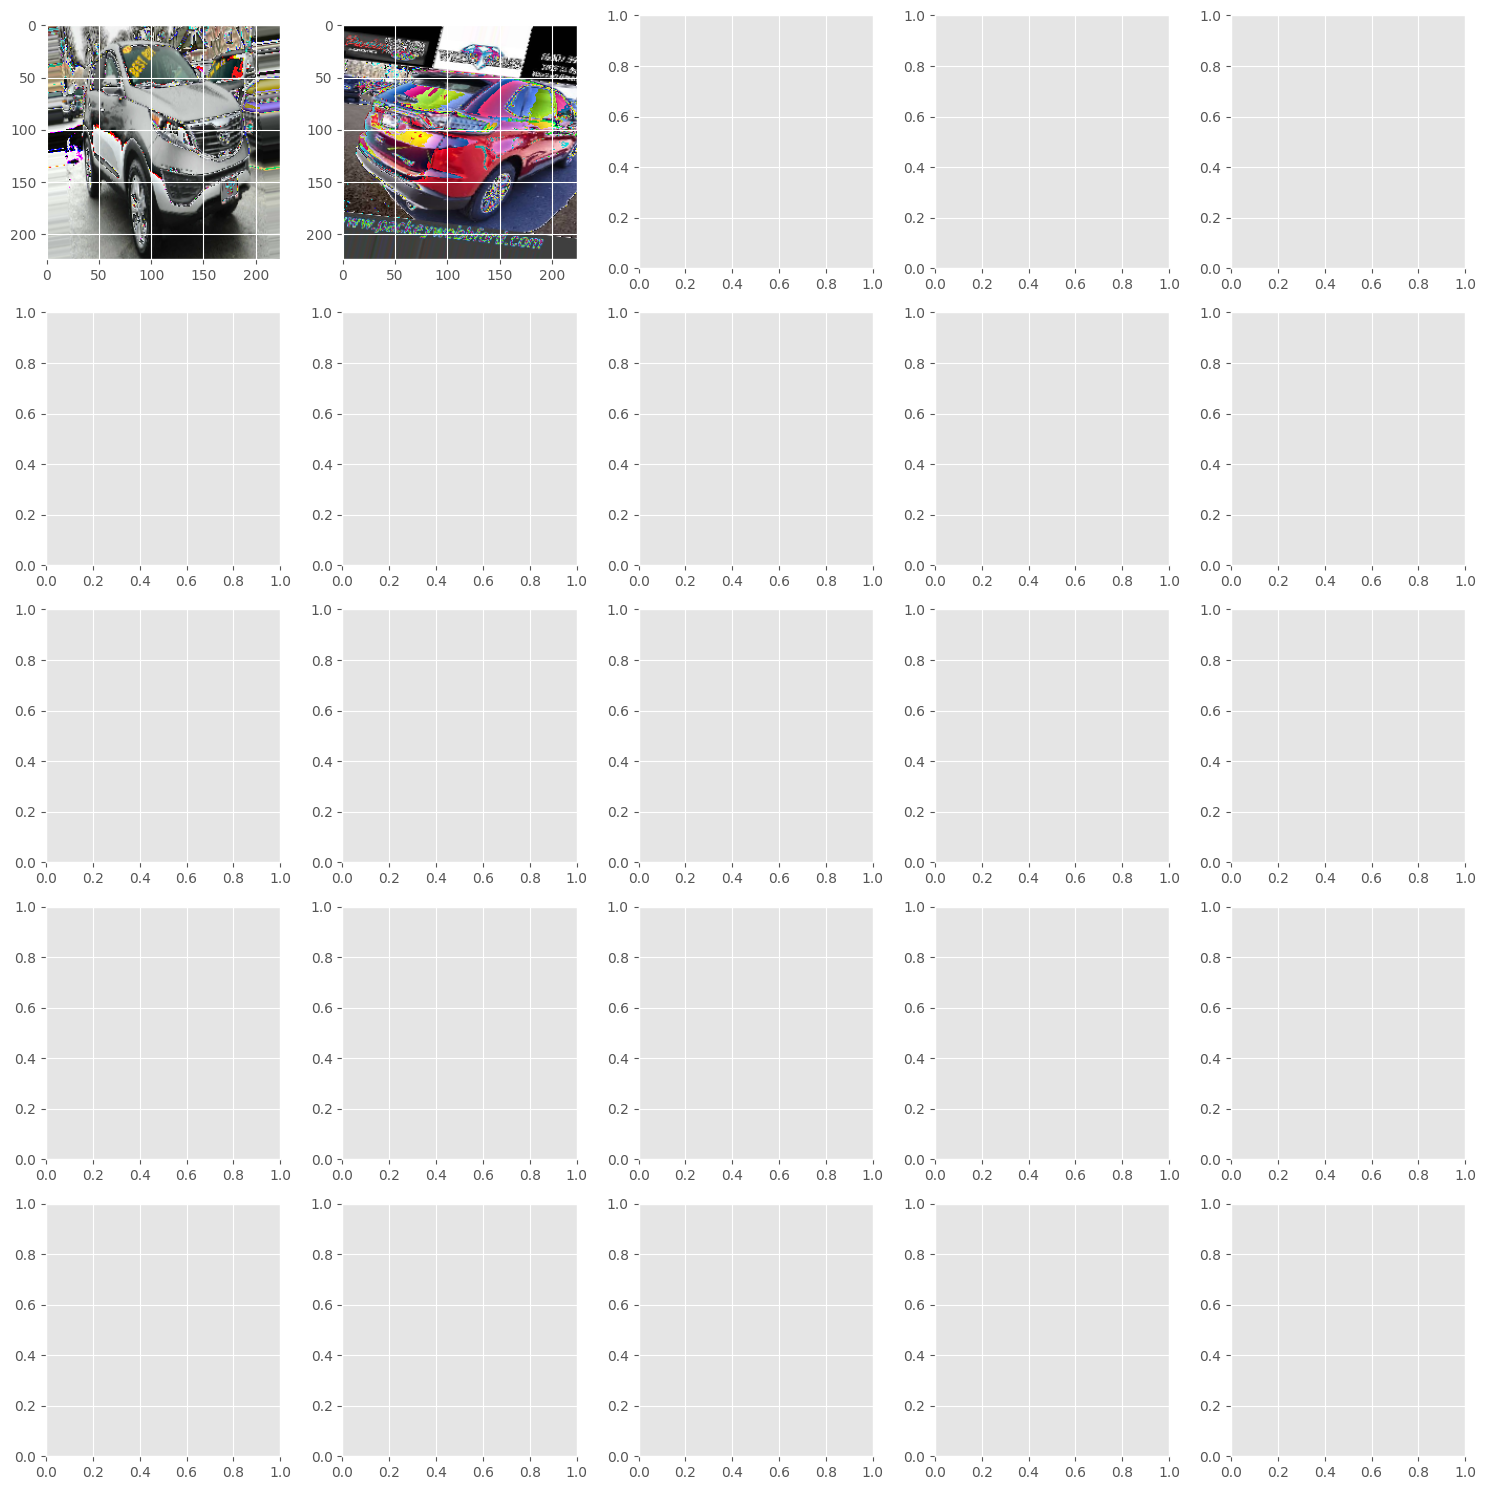

In [77]:
# see which images are misclassified for class 6 to what class
def plot_misclassified_images(cm, test_generator):
    """Plot misclassified images
    
    Args:
        cm: confusion matrix
        test_generator: test data generator
        
    Returns:
        Plot
    """
    misclassified_idx = np.where(cm[6] != 0)[0]
    n = len(misclassified_idx)
    num_row, num_col = 5, 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    for i in range(n):
        img = np.array(test_generator[misclassified_idx[i]][0][0] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plot_misclassified_images(cm, test_generator)


In [78]:
rep = classification_report( np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))
print(rep)

C:\Users\bhanu\AppData\Local\Temp\ipykernel_12764\525773473.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  rep = classification_report( np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       0.98      0.92      0.95        50
           2       0.96      1.00      0.98        50
           3       0.96      0.96      0.96        50
           4       0.98      0.90      0.94        50
           5       0.93      1.00      0.96        50
           6       0.92      0.98      0.95        50
           7       0.96      0.92      0.94        50
           8       1.00      0.96      0.98        50

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

Confusion matrix, without normalization
[[49  0  0  0  0  1  0  0  0]
 [ 0 46  1  1  1  1  0  0  0]
 [ 0  0 50  0  0  0  0  0  0]
 [ 1  1  0 47  1  0  0  0  0]
 [ 0  0  0  0 47  0  3  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  1  0 49  0  0]
 [ 0  0  0  0  0  2  0 48  0]
 [ 0  0  0  0  0  1  0  1 48]]


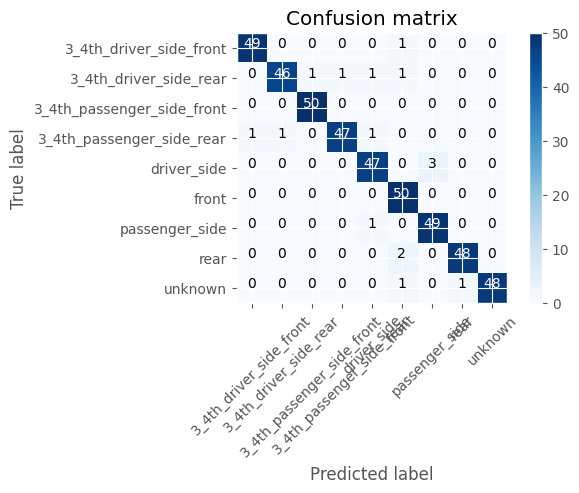

In [79]:
plot_confusion_matrix(cm, list(test_generator.class_indices.keys()),
                          normalize=False,
                          title='Confusion matrix',
                          )

In [45]:
## Test data preprocessing (With same preprocessing function from train & validation)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    # rescale = 1/255.0, # No need to scale as the inceptionV3 model already scales data between (-1,1)
    rotation_range=10,
    zoom_range=0.4,
    horizontal_flip=False
    )


TEST_DIR = 'data/test/'
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224), shuffle=False #--consistent predictions
)


Found 450 images belonging to 9 classes.


In [46]:
# for cls in os.listdir('data/test/'):
#     print(cls)

P = []
for i in range(9):
    p = 'data/test/'
    cls = random.choice(os.listdir('data/test/'))
    p += (cls) + '/'
    print(p)
    file = random.choice(os.listdir(p))
    p += (file)
    P.append(p)
print(P)

data/test/3_4th_passenger_side_front/
data/test/3_4th_passenger_side_rear/
data/test/unknown/
data/test/driver_side/
data/test/rear/
data/test/3_4th_passenger_side_front/
data/test/3_4th_passenger_side_rear/
data/test/unknown/
data/test/unknown/
['data/test/3_4th_passenger_side_front/72189.jpg', 'data/test/3_4th_passenger_side_rear/14249.jpg', 'data/test/unknown/207384.jpg', 'data/test/driver_side/1132.jpg', 'data/test/rear/137591.jpg', 'data/test/3_4th_passenger_side_front/58243.jpg', 'data/test/3_4th_passenger_side_rear/68189.jpg', 'data/test/unknown/27843.jpg', 'data/test/unknown/20117.jpg']


(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(480, 640, 3)
(480, 640, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)


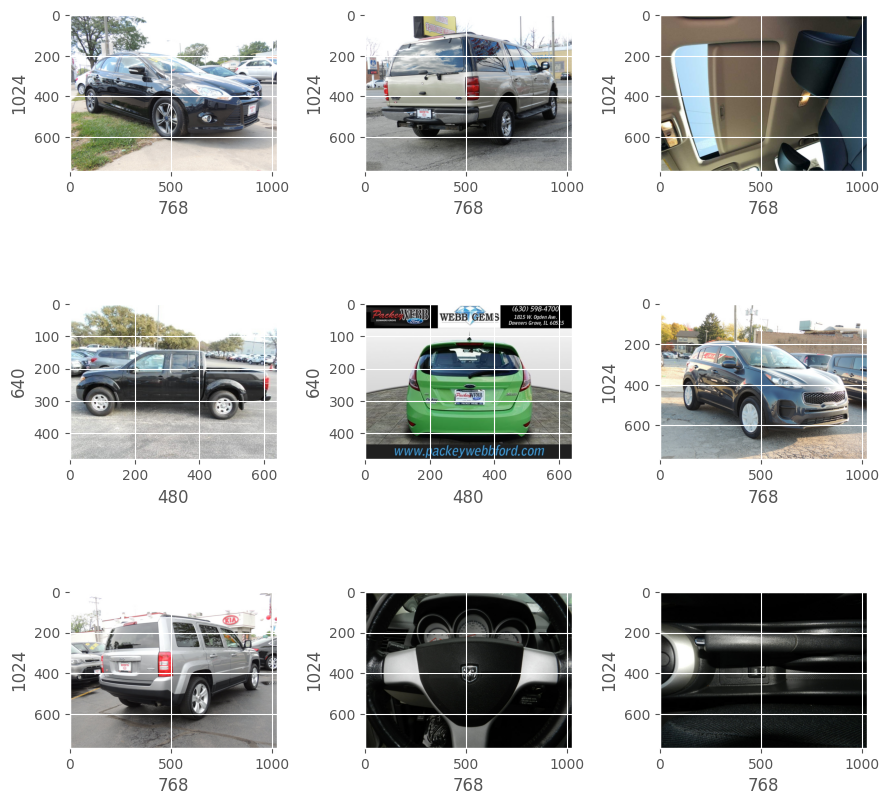

In [47]:
n = 9
num_row, num_col = 3, 3
fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))

for i in range(n):
  img = imread(P[i])
  ax = axes[i // num_col, i % num_col]
  ax.set_xlabel(f'{img.shape[0]}')
  ax.set_ylabel(f'{img.shape[1]}')
  print(img.shape)
  ax.imshow(img)
      
plt.tight_layout()
plt.show()


## Improving Model

## **Thoughts on improving the model accuracy**

In [ ]:
#Please add your thoughts on way to improve the model.
## Can experiment more with Data Agumentation by using different set of built in functions and parameters(Distortion etc)
## Combination of Learning rate schedules can be adopted 
## Can try more epochs, more than 10
## regularization techniques like weight decay can be adjusted according to loss function

## You can train the model with previous weights by freezing the base layers and unfreezing top again

In [ ]:
### The above method is to just a thought for improving accuracy---Forcely Stoping the compilation 
### You can see there is improvement of val_accuracy after adjusting first epoch
### with is lr and more epochs higher accuracy can be achieved (remember to add another Dropout layer)